<a href="https://colab.research.google.com/github/mjgpinheiro/Econophysics/blob/main/An%C3%A1lise_de_Probabilidade_de_Desenvolvimento_Futuro_dos_Pa%C3%ADses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-2-f359283083c1>:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=development_index.index, y=development_index['development_index'], palette='viridis')


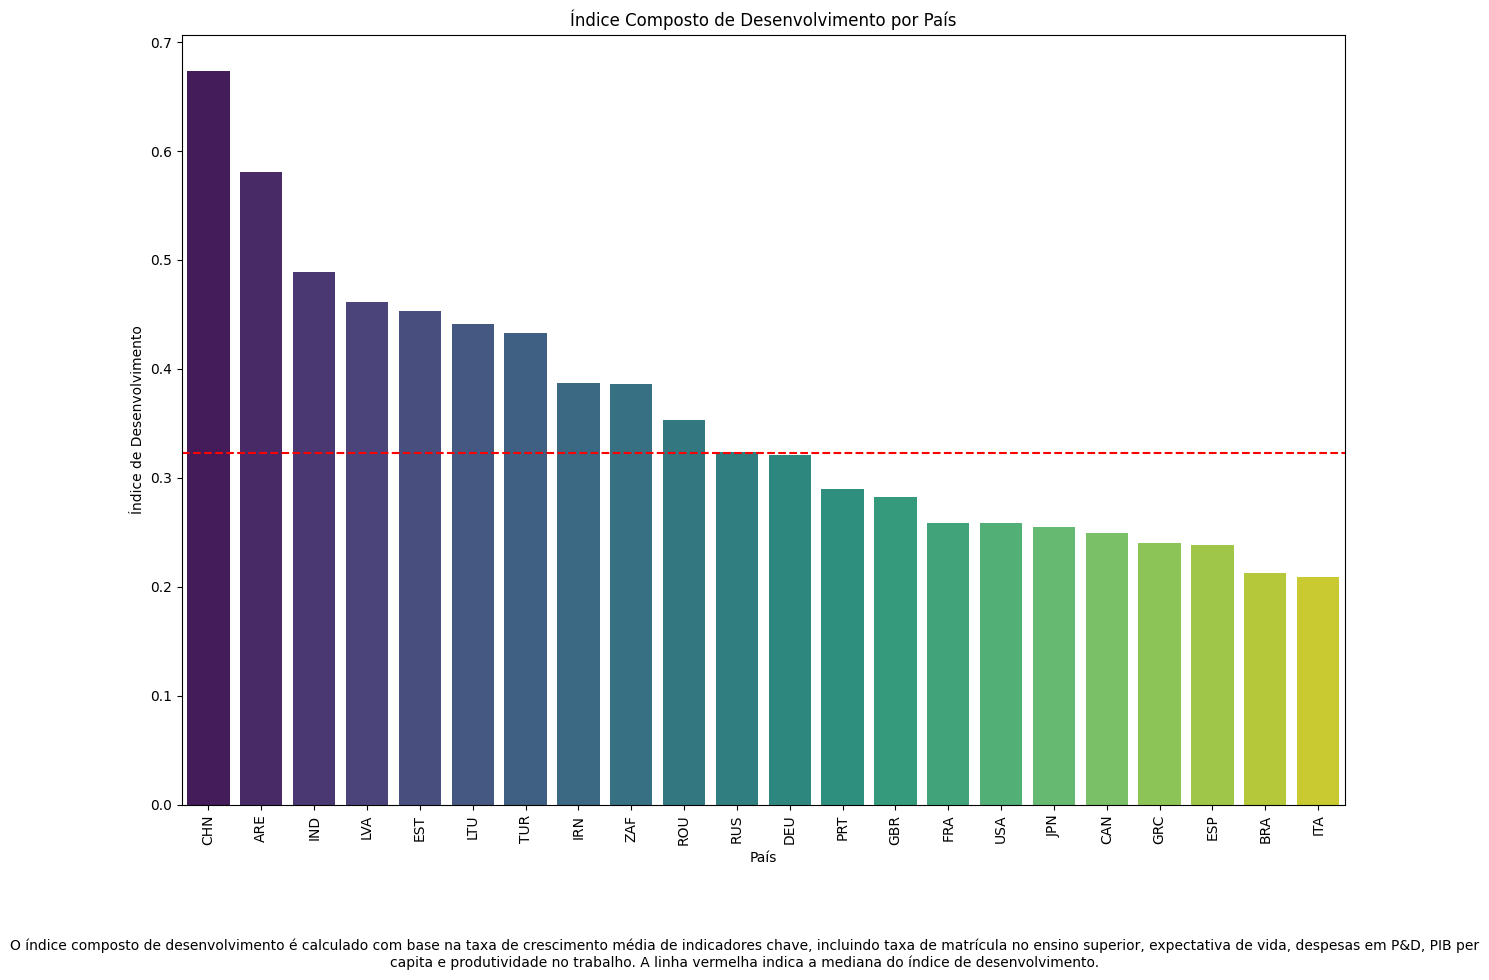

Países com maior probabilidade de desenvolvimento no futuro próximo:
['CHN', 'ARE', 'IND', 'LVA', 'EST', 'LTU', 'TUR', 'IRN', 'ZAF', 'ROU']


In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Função para buscar dados da API do Banco Mundial
def fetch_world_bank_data(indicator, country_codes):
    all_data = []
    for country in country_codes:
        url = f"http://api.worldbank.org/v2/country/{country}/indicator/{indicator}?format=json&per_page=1000&date=2010:2020"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            if data and len(data) > 1:
                df = pd.DataFrame(data[1])
                df = df[['countryiso3code', 'date', 'value']].dropna().rename(columns={'countryiso3code': 'country', 'value': indicator})
                all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

# Lista de países (códigos ISO3) para incluir na análise
country_codes = ['USA', 'CAN', 'GBR', 'FRA', 'DEU', 'CHN', 'JPN', 'IND', 'BRA', 'ZAF', 'PRT', 'MAR', 'ESP', 'ROU', 'ITA', 'GRC', 'ARE', 'IRN', 'RUS', 'TUR',
                 'EST', 'LVA', 'LTU']  # Incluindo países bálticos: Estônia, Letônia e Lituânia

# Buscar dados para diferentes indicadores
indicators = {
    'education': 'SE.TER.ENRR',  # Taxa de matrícula no ensino superior
    'health': 'SP.DYN.LE00.IN',  # Expectativa de vida
    'rnd': 'GB.XPD.RSDV.GD.ZS',  # Despesa em P&D (% do PIB)
    'gdp_per_capita': 'NY.GDP.PCAP.CD',  # PIB per capita como um proxy para felicidade
    'productivity': 'NY.GDP.PCAP.PP.KD'  # PIB por trabalhador (US$ constantes de 2011)
}

# Criar um DataFrame para armazenar os dados históricos
historical_data = {}
for key, indicator in indicators.items():
    historical_data[key] = fetch_world_bank_data(indicator, country_codes)

# Calcular a taxa de crescimento anual para cada indicador
growth_rates = {}
for key, df in historical_data.items():
    df['date'] = df['date'].astype(int)
    df.sort_values(by=['country', 'date'], inplace=True)
    df['growth_rate'] = df.groupby('country')[indicators[key]].pct_change()
    growth_rates[key] = df.dropna()

# Determinar a tendência predominante (crescimento, declínio, estagnação) para cada país
def classify_trend(df):
    trend_summary = df.groupby('country')['growth_rate'].mean().reset_index()
    trend_summary['trend'] = np.where(trend_summary['growth_rate'] > 0.02, 'Crescimento',
                                      np.where(trend_summary['growth_rate'] < -0.02, 'Declínio', 'Estagnação'))
    return trend_summary

trend_summaries = {key: classify_trend(df) for key, df in growth_rates.items()}

# Calcular um índice composto de desenvolvimento
def compute_development_index(trend_summaries):
    dev_index = pd.DataFrame()
    for key, df in trend_summaries.items():
        df = df[['country', 'growth_rate']]
        df = df.rename(columns={'growth_rate': f'{key}_growth_rate'})
        if dev_index.empty:
            dev_index = df
        else:
            dev_index = pd.merge(dev_index, df, on='country', how='inner')

    # Normalizar os dados
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(dev_index.iloc[:, 1:])
    normalized_df = pd.DataFrame(normalized_data, columns=dev_index.columns[1:], index=dev_index['country'])

    # Calcular o índice composto com pesos iguais
    normalized_df['development_index'] = normalized_df.mean(axis=1)
    return normalized_df

development_index = compute_development_index(trend_summaries)

# Classificar países com base no índice composto
development_index = development_index.sort_values(by='development_index', ascending=False)
top_countries = development_index.index.tolist()

# Visualizar o índice de desenvolvimento
plt.figure(figsize=(15, 10))
sns.barplot(x=development_index.index, y=development_index['development_index'], palette='viridis')
plt.axhline(y=development_index['development_index'].median(), color='r', linestyle='--')
plt.xticks(rotation=90)
plt.title('Índice Composto de Desenvolvimento por País')
plt.xlabel('País')
plt.ylabel('Índice de Desenvolvimento')
plt.figtext(0.5, -0.05, ("O índice composto de desenvolvimento é calculado com base na taxa de crescimento média de indicadores chave, incluindo taxa de matrícula no ensino superior, "
                         "expectativa de vida, despesas em P&D, PIB per capita e produtividade no trabalho. A linha vermelha indica a mediana do índice de desenvolvimento."), wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

# Imprimir os países com maior probabilidade de desenvolvimento
print("Países com maior probabilidade de desenvolvimento no futuro próximo:")
print(top_countries[:10])

